Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [813]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Exception ignored in: <function tqdm.__del__ at 0x7f8bb2f3d0e0>
Traceback (most recent call last):
  File "/Users/sand/lib/python3.7/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/Users/sand/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [814]:
RANDOM_SEED = 42

In [815]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [816]:
data = pd.read_csv('data/df_moscow_all_upd.csv')
data.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,67.03,1.32,20155.00,1.05,0,0,-1
1,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,58.35,1.25,21239.34,1.03,0,0,-1
2,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,62.71,1.22,21774.57,1.04,0,0,-1
3,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,64.74,1.17,22704.35,1.03,0,0,-1
4,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,72.15,1.14,23396.83,1.05,0,0,-1


In [817]:
# Есть странные колонки заканчивающиеся на .1 и .2 - объединяем с нормальным кодом
for col in [c for c in data.columns if c.endswith('.1') or c.endswith('.2')]:
    if col[0:8] in data.columns :
        data[col[0:8]] = data[col[0:8]] + data[col]
        data.drop(col, axis=1, inplace=True)

In [818]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65374 entries, 0 to 65373
Data columns (total 130 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    inn                65374 non-null  int64  
 1    ogrn               65374 non-null  int64  
 2    main_okved         65374 non-null  object 
 3    name               65374 non-null  object 
 4    address            65374 non-null  object 
 5    type               65374 non-null  object 
 6    status             65374 non-null  object 
 7    okved              65374 non-null  object 
 8    date_reg           65374 non-null  object 
 9    comments           11764 non-null  object 
 10   year               65374 non-null  int64  
 11   ind_1250           65374 non-null  int64  
 12   ind_1230           65374 non-null  int64  
 13   ind_1600           65374 non-null  int64  
 14   ind_1300           65374 non-null  int64  
 15   ind_1520           65374 non-null  int64  
 16   in

In [819]:
# Сразу типмизируем, чтоб не путаться
data['inn'] = data['inn'].astype(str)
data['ogrn'] = data['ogrn'].astype(str)
data['main_okved'] = data['main_okved'].astype(str)
data['name'] = data['name'].astype(str)
data['address'] = data['address'].astype(str)
data['type'] = data['type'].astype(str)
data['status'] = data['status'].astype(str)
#data['okved'] = data['okved'].apply(lambda x: x[1:-1].split(','))
data['date_reg'] = pd.to_datetime(data['date_reg'])
data['comments'] = data['comments'].astype(str)
data['year'] = data['year'].astype(int)
data[[c for c in data.columns if c.startswith('ind_')]] = data[[c for c in data.columns if c.startswith('ind_')]].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65374 entries, 0 to 65373
Data columns (total 130 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    inn                65374 non-null  object        
 1    ogrn               65374 non-null  object        
 2    main_okved         65374 non-null  object        
 3    name               65374 non-null  object        
 4    address            65374 non-null  object        
 5    type               65374 non-null  object        
 6    status             65374 non-null  object        
 7    okved              65374 non-null  object        
 8    date_reg           65374 non-null  datetime64[ns]
 9    comments           65374 non-null  object        
 10   year               65374 non-null  int64         
 11   ind_1250           65374 non-null  float64       
 12   ind_1230           65374 non-null  float64       
 13   ind_1600           65374 non-null  float64  

In [820]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
additional_features.remove('ind_2400')
investments = data.sort_values(by=['inn', 'year']).groupby('inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')
data = data.join(investments, on=['inn'])
data[['inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,inn,year,inv_year,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
0,7721452574,2016,2016,20155.00,5044.00,3590.00,14412.00,15345.00,20155.00,0.00,...,0.00,0.00,0.00,0.00,-300.00,0.00,0.00,0.00,0.00,0.00
1,7721452574,2017,2016,20155.00,5044.00,3590.00,14412.00,15345.00,20155.00,0.00,...,0.00,0.00,0.00,0.00,-300.00,0.00,0.00,0.00,0.00,0.00
2,7721452574,2018,2016,20155.00,5044.00,3590.00,14412.00,15345.00,20155.00,0.00,...,0.00,0.00,0.00,0.00,-300.00,0.00,0.00,0.00,0.00,0.00
3,7721452574,2019,2016,20155.00,5044.00,3590.00,14412.00,15345.00,20155.00,0.00,...,0.00,0.00,0.00,0.00,-300.00,0.00,0.00,0.00,0.00,0.00
4,7721452574,2020,2016,20155.00,5044.00,3590.00,14412.00,15345.00,20155.00,0.00,...,0.00,0.00,0.00,0.00,-300.00,0.00,0.00,0.00,0.00,0.00


In [821]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['inn', 'year']).groupby('inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['inn', 'year']).head()

,inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
57635,1102068218,2011,3822.00,3822.00,2011,68947.00,154.00,100.00,6780.00,66687.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57636,1102068218,2012,-2245.00,1577.00,2011,68947.00,154.00,100.00,6780.00,66687.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57637,1102068218,2013,-2366.00,-789.00,2011,68947.00,154.00,100.00,6780.00,66687.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57638,1102068218,2014,-1132.00,-1921.00,2011,68947.00,154.00,100.00,6780.00,66687.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57639,1102068218,2015,-1870.00,-3791.00,2011,68947.00,154.00,100.00,6780.00,66687.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [822]:
data.sort_values(by=['inn', 'year']).groupby('inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
inn,,,,,,,,,,,,,,,,,,,,,
1102068218,2020,-223.00,2119.00,2011,68947.00,154.00,100.00,6780.00,66687.00,68947.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1650329732,2021,14218.00,21636.00,2016,2074.00,100.00,2012.00,219.00,33.00,2074.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1655298774,2020,-6374.00,43859.00,2014,6971.00,1.00,13920.00,20835.00,0.00,6971.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1655300448,2020,3266.00,5438.00,2014,1241.00,7.00,96.00,495.00,199.00,1241.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2310172571,2020,13031.00,50574.00,2013,5180.00,2645.00,2964.00,-10476.00,3430.00,5180.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [823]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [824]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328,profit,result
17173,7725300068,5157746170270,63.11,"ООО ""ЦЕНТР ОРГАНИЗАЦИИ ДОКУМЕНТООБОРОТА""","119071, г. Москва, ул. Малая Калужская, 15, эт. 1 помещ. /ком 10/1",коммерческая,действующая,"['62.01', '62.02', '63.11.1', '69.10', '70.22', '74.30', '82.19', '82.99']",2015-12-17,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,766.00,-756.00
45864,7703375711,1157746354688,62.02,"ООО ""АИП МЕДИА""","101000, г. Москва, ул. Маросейка, 3/13 стр. 1, эт 4 пом 1Л",коммерческая,ликвидирована,"['62.01', '62.09']",2015-04-16,Организация ликвидирована 19.10.2020.,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-7581.00,17146.00


In [825]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['inn', 'year']).groupby('inn').last(),
           data[data['result'] <= 0].sort_values(by=['inn', 'year']).groupby('inn').first()]).reset_index()
temp = temp.sort_values(by=['inn', 'year']).groupby(['inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328,profit,result
3860,7716833454,1167746861369,63.11,"ООО ""РЕАЛТИПОН""","129344, г. Москва, ул. Енисейская, 1 стр. 8, помещ. 36/1",коммерческая,действующая,"['18.12', '58.11.2', '58.19', '58.21', '63.11.1', '63.11.9', '63.12', '63.99', '63.99.2', '68.31']",2016-09-14,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4451.00,-4437.00
9585,7743027781,1147748157853,62.09,"ООО ""ТЕХНОЛОГИИ ИНТЕРНЕТ- ПРОДАЖ""","125475, г. Москва, ул. Клинская, 10 корп. 2, кв. 23",коммерческая,действующая,"['46.66', '46.90', '47.19', '47.59.9', '47.63.1', '47.63.2', '47.73', '47.74', '47.75', '47.79']",2014-12-27,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [826]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328,profit,result,target
9851,7743277830,1187746865790,62.09,"ООО ""ЭКОБИСЛОГИСТИК""","125412, г. Москва, ш Коровинское, 35 стр. 4, эт 2 оф 225А",коммерческая,ликвидирована (исключение из ЕГРЮЛ юридического лица в связи наличием в ЕГРЮЛ сведений о нем,"['18.12', '18.20', '43.21', '45.11', '45.20', '46.71', '46.71.9', '46.72', '46.73', '46.75']",2018-10-11,Организация ликвидирована 03.11.2021.,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,799.00,-749.00,2
8802,7733274157,1167746245897,58.14,"ООО ""КРАСНОЕ СОЛНЦЕ""","125363, г. Москва, ул. Штурвальная, 1, кв. 127",коммерческая,ликвидирована (прекращение деятельности юридического лица в связи с исключением из ЕГРЮЛ на основании п.2 ст.21.1 Федерального закона от 08.08.2001 №129-ФЗ),"['18.12', '46.18', '46.43.3', '46.49.3', '46.90', '47.19', '47.61', '47.63.1', '47.63.2', '47.99']",2016-03-10,Организация ликвидирована 07.10.2021.,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.00,-1.00,0


In [827]:
# В рабочий набор берем только коммерческие организации
work_df = temp.loc[temp['type'] == 'коммерческая', ['inn', 'main_okved', 'inv_sum', 'target'] + ['inv_' + x for x in additional_features]]
work_df.head()

,inn,main_okved,inv_sum,target,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
0,1102068218,62.01,68947.00,-1,154.00,100.00,6780.00,66687.00,68947.00,21965.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1650329732,62.01,2074.00,4,100.00,2012.00,219.00,33.00,2074.00,260.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1655298774,62.01,6971.00,1,1.00,13920.00,20835.00,0.00,6971.00,6955.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1655300448,62.09,1241.00,1,7.00,96.00,495.00,199.00,1241.00,323.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2310172571,62.09,5180.00,5,2645.00,2964.00,-10476.00,3430.00,5180.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### EDA

In [828]:
for f in work_df.columns:
    first_look(work_df[f])

--------------------------------------------------------------------------------
Название: inn
Тип данных: <class 'numpy.object_'>
Количество значений: 12401
Количество уникальных значений: 12401
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count          12401
unique         12401
top       1102068218
freq               1
Name: inn, dtype: object
Топ 10 уникальных значений:
1102068218    1
7730206046    1
7730224447    1
7730225401    1
7730227078    1
7730230546    1
7730230585    1
7730230955    1
7730231236    1
7730231684    1
Name: inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: main_okved
Тип данных: <class 'numpy.object_'>
Количество значений: 12401
Количество уникальных значений: 65
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     12401
unique       65
top       62.01
freq       4259
Name: 

### Первая модель - LR

In [829]:
# Формируем X
# Масштабируем числовые признаки
X = pd.DataFrame([], index=work_df.index)
X[['inv_sum'] + ['inv_' + x for x in additional_features]] = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X.sample(2)

,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,inv_ind_2120,inv_ind_2350,inv_ind_1210,...,inv_ind_6350,inv_ind_6240,inv_ind_4112,inv_ind_6330,inv_ind_4229,inv_ind_6310,inv_ind_4223,inv_ind_4222,inv_ind_4318,inv_ind_4328
3758,-0.01,-0.06,-0.11,-0.01,-0.10,-0.01,-0.12,0.11,0.07,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11254,-0.01,-0.06,-0.11,-0.01,-0.10,-0.01,-0.12,0.11,0.07,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [830]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved']]).astype(int)
X.sample(2)

,inv_sum,inv_ind_1250,inv_ind_1230,inv_ind_1300,inv_ind_1520,inv_ind_1700,inv_ind_2110,inv_ind_2120,inv_ind_2350,inv_ind_1210,...,x0_90.02,x0_90.03,x0_90.04,x0_91.01,x0_91.02,x0_91.03,x0_91.04,x0_93.1,x0_93.2,x0_94.12
2871,-0.01,-0.05,0.42,-0.01,0.29,-0.01,0.15,-0.18,-0.00,-0.07,...,0,0,0,0,0,0,0,0,0,0
4336,-0.01,-0.06,-0.11,-0.01,-0.10,-0.01,-0.12,0.11,0.07,-0.07,...,0,0,0,0,0,0,0,0,0,0


In [831]:
# В таргет берем только признак окупиться/не окупится
y = (work_df['target'] != -1).astype(int)
y.unique()

array([0, 1])

In [832]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((12401, 171), (12401,), (9920, 171), (9920,), (2481, 171), (2481,))

In [833]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7019297170293187

В принципе результат не плохой - можно работать дальше

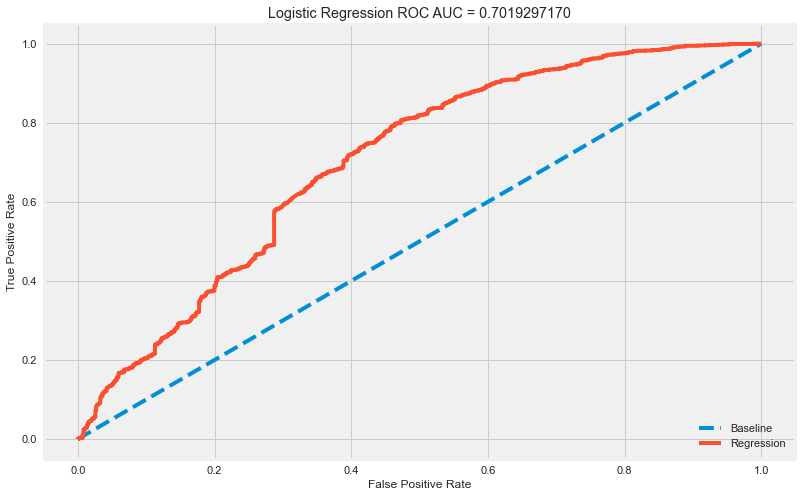

In [834]:
show_roc_auc(y_valid, y_prob[:, 1])

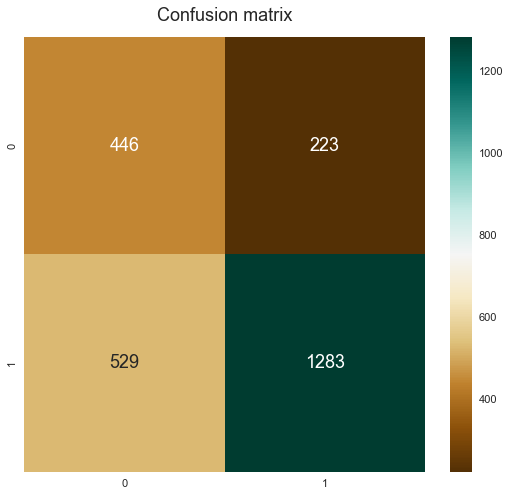

In [835]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

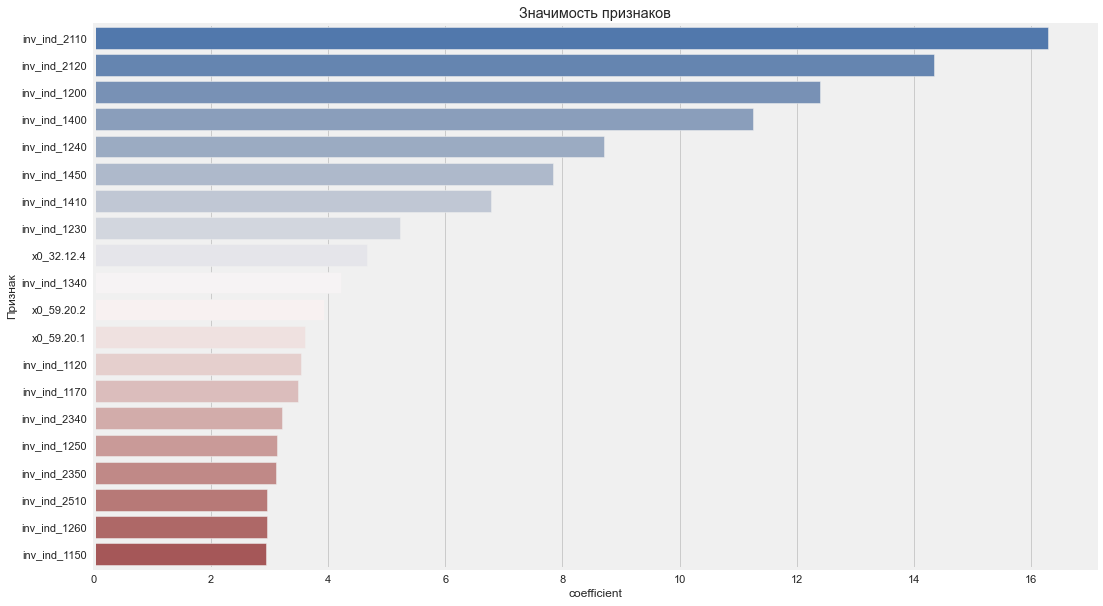

In [836]:
show_lr_Importance(lr, X.columns)

### LGBMClassifier

In [837]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.8009415330132461

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

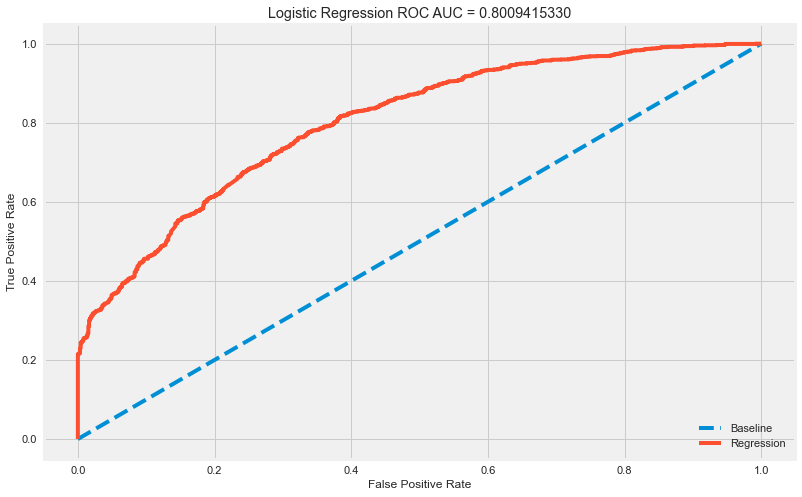

In [838]:
show_roc_auc(y_valid, y_prob[:, 1])

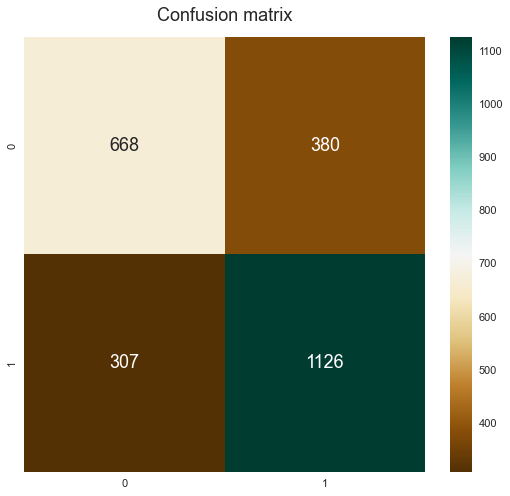

In [839]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

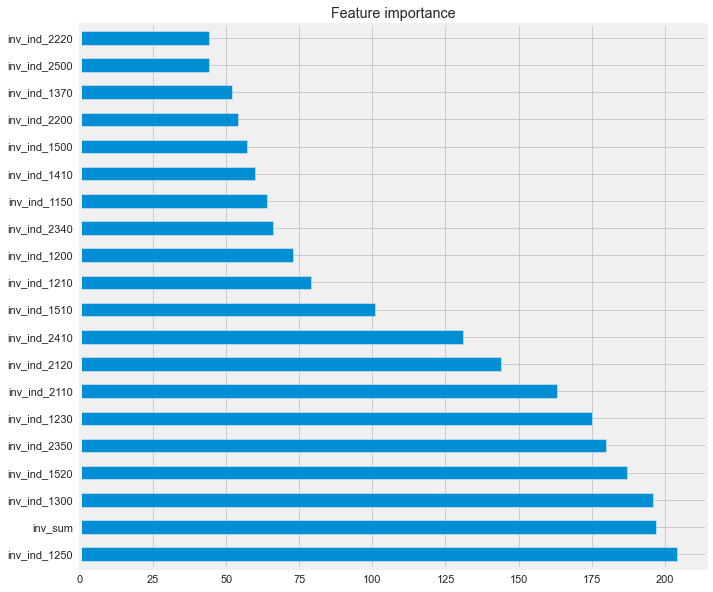

In [840]:
plot_feature_importances(model.feature_importances_, X.columns)

### Предсказание срока выхода из убытков

In [841]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
features = ['inv_sum']
# features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[features] = preprocessing.StandardScaler().fit_transform(work_df[features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved']]).astype(int)
y = work_df['target']
X.shape, y.shape

((12401, 66), (12401,))

In [842]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((12401, 66), (12401,), (9920, 66), (9920,), (2481, 66), (2481,))

In [843]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, multi_class='ovr')

0.7141763280729246

In [844]:
cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovr_weighted')

array([0.70884532, 0.70148897, 0.69394527, 0.69661873, 0.68980943])

На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

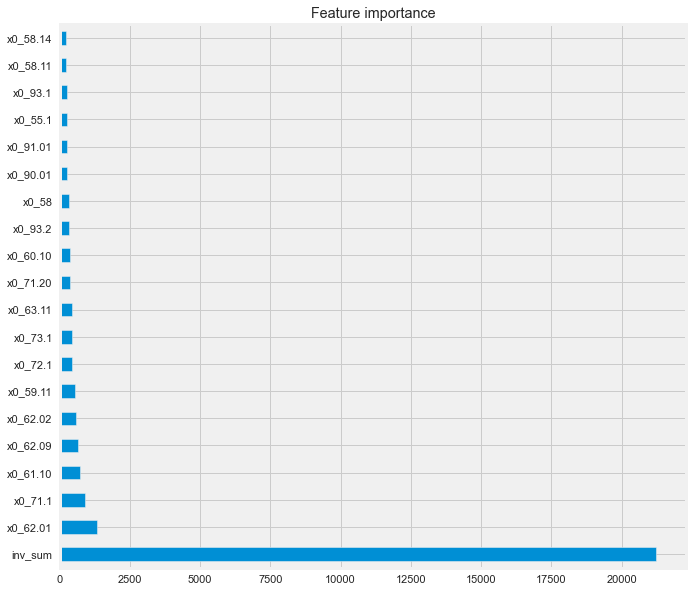

In [845]:
plot_feature_importances(model.feature_importances_, X.columns)

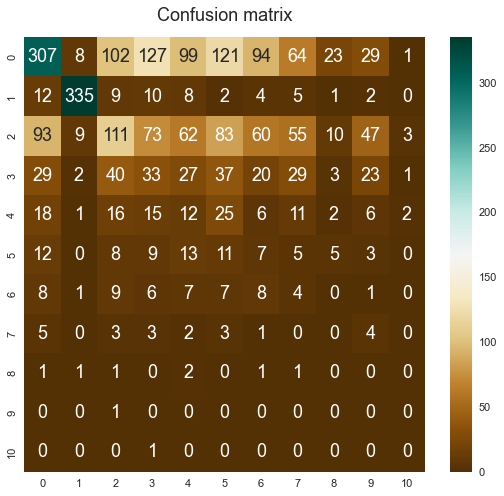

In [846]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [847]:
list(zip(y_pred, y_valid))[100:110]

[(2, -1),
 (2, -1),
 (0, -1),
 (4, 1),
 (-1, -1),
 (4, 3),
 (4, 3),
 (2, -1),
 (-1, -1),
 (4, 2)]

In [848]:
model = LGBMRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.mean_absolute_error(y_valid, y_pred)

1.1742376907962706

In [849]:
list(zip(np.round(y_pred), y_valid))[100:110]

[(-0.0, -1),
 (1.0, -1),
 (1.0, -1),
 (1.0, 1),
 (-0.0, -1),
 (1.0, 3),
 (1.0, 3),
 (1.0, -1),
 (-0.0, -1),
 (1.0, 2)]